# **Transfer Learning in MRI Tumor classification model**


## pre-trained model과 untrained model 학습 및 성능 비교

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

# 기본 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/content/drive/MyDrive/MRI/'
batch_size = 32
epochs = 10
lr = 1e-4

# 전처리 설정
tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ImageFolder로 데이터셋 로드
dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=tfms)

# stratified 방식으로 train/validation 세트 분리
def stratified_split(dataset, test_size=0.2):
    targets = [label for _, label in dataset.imgs]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, val_idx = next(sss.split(dataset.imgs, targets))
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

train_set, val_set = stratified_split(dataset)
test_set = datasets.ImageFolder(os.path.join(data_dir, 'Testing'), transform=tfms)

# 데이터 로더 설정
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
# VGG16 모델 로드 및 수정 (이진 분류)
def get_vgg(weights):
    model = models.vgg16(weights=weights)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    return model.to(device)

# Pre-trained와 Untrained VGG16 모델 로드
pre_vgg = get_vgg(weights=models.VGG16_Weights.IMAGENET1K_V1)
un_vgg = get_vgg(weights=None)

# 학습 및 평가 함수
def train_and_evaluate(model, optimizer, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train = 0.0, 0

        # Training step
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data).item()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_acc = correct_train / len(train_loader.dataset)
        train_accs.append(train_acc)

        # Validation step
        model.eval()
        running_val_loss, correct_val = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels.data).item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        val_acc = correct_val / len(val_loader.dataset)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# 옵티마이저 설정 및 모델 학습
opt_pre = optim.Adam(pre_vgg.parameters(), lr=lr)
opt_un = optim.Adam(un_vgg.parameters(), lr=lr)

print("Pre-trained VGG16 모델 학습 중...")
train_loss_pre, val_loss_pre, train_acc_pre, val_acc_pre = train_and_evaluate(pre_vgg, opt_pre, train_loader, val_loader, epochs)

print("Untrained VGG16 모델 학습 중...")
train_loss_un, val_loss_un, train_acc_un, val_acc_un = train_and_evaluate(un_vgg, opt_un, train_loader, val_loader, epochs)

# 모델 저장
torch.save(pre_vgg.state_dict(), os.path.join(data_dir, 'vgg16_pretrained.pth'))
torch.save(un_vgg.state_dict(), os.path.join(data_dir, 'vgg16_untrained.pth'))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.8MB/s]


Pre-trained VGG16 모델 학습 중...
Epoch 1/10, Train Loss: 0.2514, Train Acc: 0.8911, Val Loss: 0.1377, Val Acc: 0.9563
Epoch 2/10, Train Loss: 0.0830, Train Acc: 0.9736, Val Loss: 0.0618, Val Acc: 0.9812
Epoch 3/10, Train Loss: 0.0538, Train Acc: 0.9820, Val Loss: 0.1106, Val Acc: 0.9613
Epoch 4/10, Train Loss: 0.0709, Train Acc: 0.9767, Val Loss: 0.0535, Val Acc: 0.9825
Epoch 5/10, Train Loss: 0.0280, Train Acc: 0.9919, Val Loss: 0.0881, Val Acc: 0.9756
Epoch 6/10, Train Loss: 0.0376, Train Acc: 0.9889, Val Loss: 0.1219, Val Acc: 0.9781
Epoch 7/10, Train Loss: 0.0217, Train Acc: 0.9922, Val Loss: 0.1061, Val Acc: 0.9675
Epoch 8/10, Train Loss: 0.0418, Train Acc: 0.9888, Val Loss: 0.0956, Val Acc: 0.9719
Epoch 9/10, Train Loss: 0.0285, Train Acc: 0.9898, Val Loss: 0.0663, Val Acc: 0.9862
Epoch 10/10, Train Loss: 0.0163, Train Acc: 0.9955, Val Loss: 0.0521, Val Acc: 0.9844
Untrained VGG16 모델 학습 중...
Epoch 1/10, Train Loss: 0.5110, Train Acc: 0.7273, Val Loss: 0.3539, Val Acc: 0.8350
Epoch 2/

In [ ]:
# 테스트 함수
def test_model(model, loader):
    model.eval()
    correct = sum((torch.max(model(inputs.to(device)), 1)[1] == labels.to(device)).sum().item()
                  for inputs, labels in loader)
    return correct / len(loader.dataset)

# 두 모델 테스트
print(f"Pre-trained VGG16 Test Accuracy: {test_model(pre_vgg, test_loader):.4f}")
print(f"Untrained VGG16 Test Accuracy: {test_model(un_vgg, test_loader):.4f}")


Pre-trained VGG16 Test Accuracy: 0.9640
Untrained VGG16 Test Accuracy: 0.9290


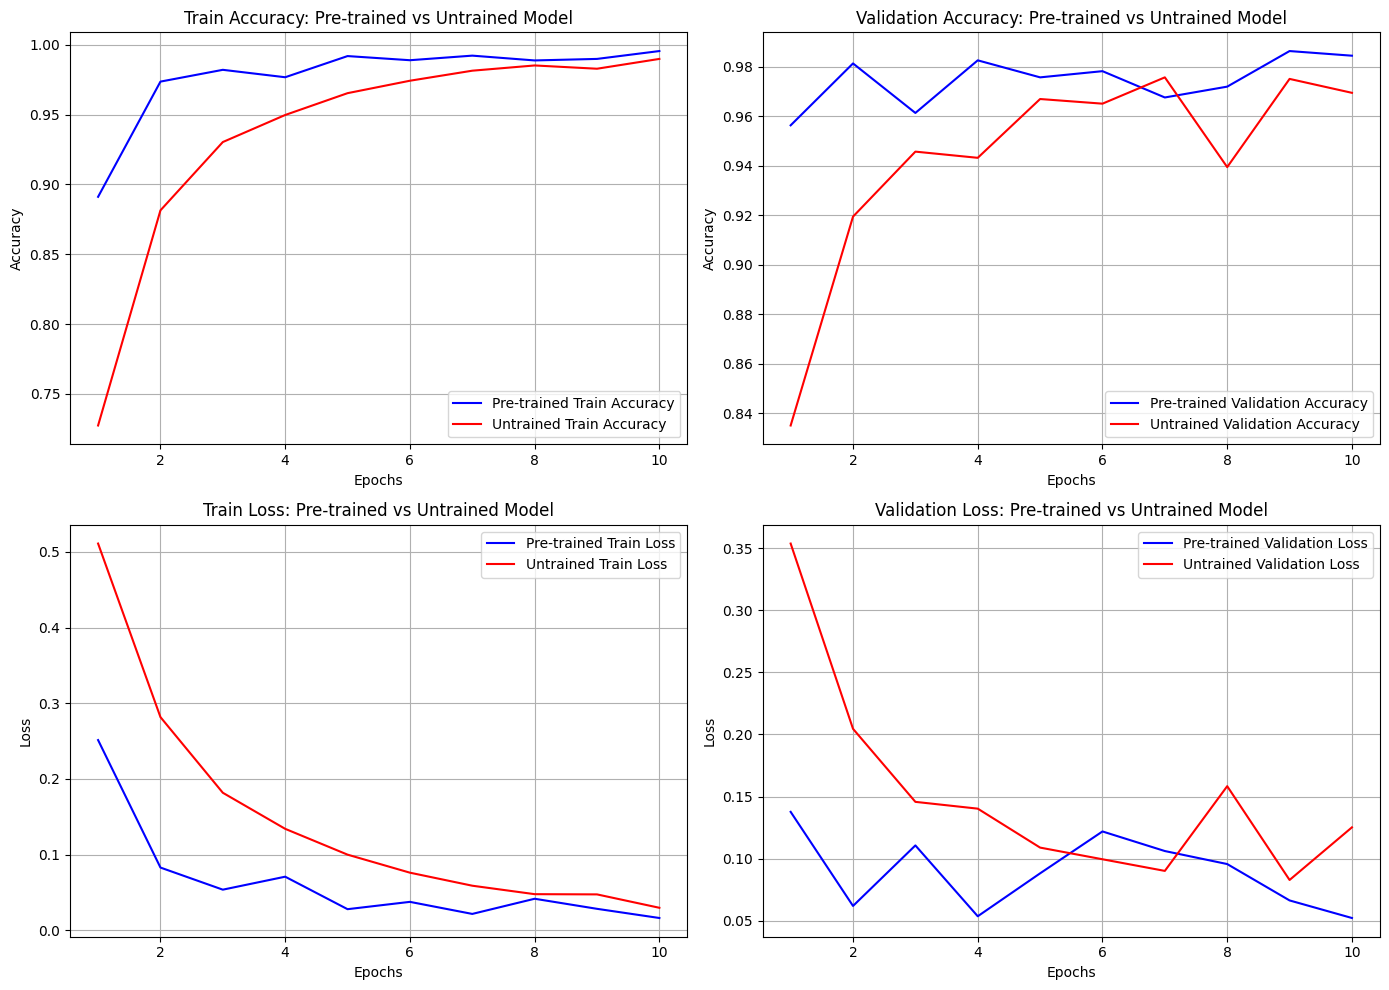

In [ ]:
import matplotlib.pyplot as plt

# 결과 시각화 함수 (2x2 배열로 비교)
def plot_results(train_acc_pre, val_acc_pre, train_acc_un, val_acc_un, train_loss_pre, val_loss_pre, train_loss_un, val_loss_un, epochs):
    epoch_range = range(1, epochs + 1)

    # 2x2 subplot 설정
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Train Accuracy 비교
    axs[0, 0].plot(epoch_range, train_acc_pre, label="Pre-trained Train Accuracy", color='b')
    axs[0, 0].plot(epoch_range, train_acc_un, label="Untrained Train Accuracy", color='r')
    axs[0, 0].set_title('Train Accuracy: Pre-trained vs Untrained Model')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Validation Accuracy 비교
    axs[0, 1].plot(epoch_range, val_acc_pre, label="Pre-trained Validation Accuracy", color='b')
    axs[0, 1].plot(epoch_range, val_acc_un, label="Untrained Validation Accuracy", color='r')
    axs[0, 1].set_title('Validation Accuracy: Pre-trained vs Untrained Model')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Train Loss 비교
    axs[1, 0].plot(epoch_range, train_loss_pre, label="Pre-trained Train Loss", color='b')
    axs[1, 0].plot(epoch_range, train_loss_un, label="Untrained Train Loss", color='r')
    axs[1, 0].set_title('Train Loss: Pre-trained vs Untrained Model')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Validation Loss 비교
    axs[1, 1].plot(epoch_range, val_loss_pre, label="Pre-trained Validation Loss", color='b')
    axs[1, 1].plot(epoch_range, val_loss_un, label="Untrained Validation Loss", color='r')
    axs[1, 1].set_title('Validation Loss: Pre-trained vs Untrained Model')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

# 결과 시각화 실행
plot_results(train_acc_pre, val_acc_pre, train_acc_un, val_acc_un, train_loss_pre, val_loss_pre, train_loss_un, val_loss_un, epochs)
